## BLD Model

In [26]:
import argparse
import os
import numpy as np
from PIL import Image

from diffusers import DDIMScheduler, StableDiffusionPipeline
import torch


class BlendedLatentDiffusion:
    def __init__(self, device):
        self.init_args(device=device)
        self.load_models()

    def init_args(self,
                  model_path = "stabilityai/stable-diffusion-2-1-base",
                  batch_size = 4,
                  blending_start_percentage = 0.25,
                  device = "cuda",
                  output_path = "outputs/res.jpg"):
         
        self.model_path = "stabilityai/stable-diffusion-2-1-base" # the path to the HuggingFace model
        
        self.batch_size = 4 # Number of images to be generated
        self.blending_start_percentage = 0.25 # The diffusion steps percentage to jump to
        self.device = device
        self.output_path = output_path
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        return (model_path, batch_size, blending_start_percentage, device, output_path)
        

    def load_models(self):
        pipe = StableDiffusionPipeline.from_pretrained(
            self.model_path, torch_dtype=torch.float16
        )
        self.vae = pipe.vae.to(self.device)
        self.tokenizer = pipe.tokenizer
        self.text_encoder = pipe.text_encoder.to(self.device)
        self.unet = pipe.unet.to(self.device)
        self.scheduler = DDIMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            clip_sample=False,
            set_alpha_to_one=False,
        )

    @torch.no_grad()
    def edit_image(
        self,
        image_path,
        mask_path,
        text_embedding,
        batch_size=1,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=7.5,
        generator=torch.manual_seed(42),
        blending_percentage=0.25,
    ):
        image = Image.open(image_path)
        image = image.resize((height, width), Image.BILINEAR)
        image = np.array(image)[:, :, :3]
        source_latents = self._image2latent(image)
        latent_mask, org_mask = self._read_mask(mask_path)

        text_embeddings = text_embedding.repeat(batch_size, 1)
        max_length = text_embeddings.shape[-1]

        uncond_input = self.tokenizer(
            [""] * batch_size,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
        )
        print("Uncod input shape: " + uncond_input.shape)
        
        uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        latents = torch.randn(
            (batch_size, self.unet.in_channels, height // 8, width // 8),
            generator=generator,
        )
        latents = latents.to(self.device).half()

        self.scheduler.set_timesteps(num_inference_steps)

        for t in self.scheduler.timesteps[
            int(len(self.scheduler.timesteps) * blending_percentage) :
        ]:
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)

            latent_model_input = self.scheduler.scale_model_input(
                latent_model_input, timestep=t
            )
            # predict the noise residual
            with torch.no_grad():
                noise_pred = self.unet(
                    latent_model_input, t, encoder_hidden_states=text_embeddings
                ).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (
                noise_pred_text - noise_pred_uncond
            )

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

            # Blending
            noise_source_latents = self.scheduler.add_noise(
                source_latents, torch.randn_like(latents), t
            )
            latents = latents * latent_mask + noise_source_latents * (1 - latent_mask)

        latents = 1 / 0.18215 * latents

        with torch.no_grad():
            image = self.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")

        return images

    @torch.no_grad()
    def _image2latent(self, image):
        image = torch.from_numpy(image).float() / 127.5 - 1
        image = image.permute(2, 0, 1).unsqueeze(0).to(self.device)
        image = image.half()
        latents = self.vae.encode(image)["latent_dist"].mean
        latents = latents * 0.18215

        return latents

    def _read_mask(self, mask_path: str, dest_size=(64, 64)):
        org_mask = Image.open(mask_path).convert("L")
        mask = org_mask.resize(dest_size, Image.NEAREST)
        mask = np.array(mask) / 255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
        mask = mask[np.newaxis, np.newaxis, ...]
        mask = torch.from_numpy(mask).half().to(self.device)

        return mask, org_mask

## Load Models

In [11]:
import torch
import transformers

from transformers import CLIPProcessor, CLIPModel

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Load the processor and the model
bld = BlendedLatentDiffusion(device=device)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/Users/amirgheser/miniconda3/envs/matting2/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


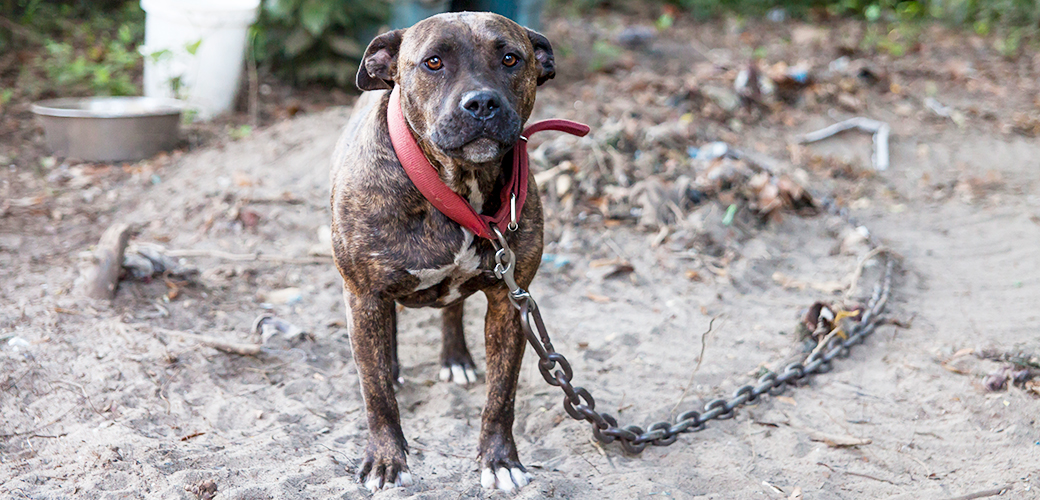

In [3]:
from PIL import Image
image_path = 'inputs/guidance.png'
image = Image.open(image_path).convert("RGB")
image

## Enforce similarity
We want to find the text embeddings via the following approximation:
$$
\frac{f^c_{img}}{\lVert f^c_{img} \rVert} \approx \frac{f^c_{txt}}{\lVert f^c_{txt} \rVert}
$$
with $ f^c_{txt} = W_t f^{t,\langle eos \rangle }_{txt} $


By using Moore-Penrose pseudoinverse on $W_t$, we obtain an estimate of $f^{t, \langle eos \rangle}_{txt}$ from $f^c_{txt}$:

$$
f^{t, \langle eos \rangle}_{txt} \approx \frac{\lVert f^c_{txt} \rVert}{\lVert f^c_{img} \rVert} W_t^+ f^c_{img}
\coloneqq f^{cnvrt}_{txt}
$$
where, $ W^+_t = (W^T_tW_t)^{-1}W^T_t $

In [13]:
@torch.no_grad()
def compute_f_cnvrt_txt(image, model, processor, device):
    # Move W_t and compute W_t^+
    W_t = model.text_projection.weight.to(device)
    W_t_plus = torch.linalg.pinv(W_t)  # Compute pseudo-inverse

    f_c_txt_norm = torch.tensor(27.0, device=device) # Empirically determined text embedding norm  

    inputs = processor(images=image, return_tensors="pt").to(device)
    f_c_img = model.get_image_features(**inputs)  # Shape: (batch_size, d_image)
    f_c_img_norm = f_c_img.norm(dim=-1, keepdim=True)  # Shape: (batch_size, 1)

    # Compute f_cnvrt_txt
    f_cnvrt_txt = (f_c_txt_norm / f_c_img_norm) * (W_t_plus @ f_c_img.T)  # Shape: (d_text, batch_size)

    f_cnvrt_txt = f_cnvrt_txt.T  # Final shape: (batch_size, d_text)

    return W_t_plus, f_c_img, f_cnvrt_txt


In [14]:
W_t_plus, f_c_img, f_cnvrt_txt = compute_f_cnvrt_txt(image, model, processor, device)
print("W_t_plus shape:", W_t_plus.shape)
print("f_c_img shape:", f_c_img.shape)
print("f_cnvrt_txt shape:", f_cnvrt_txt.shape)

W_t_plus shape: torch.Size([768, 768])
f_c_img shape: torch.Size([1, 768])
f_cnvrt_txt shape: torch.Size([1, 768])


Use the embedding to assemble the *pseudo-prompt*:

In [17]:
def generate_pseudo_prompt(f_cnvrt_txt, model, processor):
    sos_token = processor.tokenizer.bos_token
    inputs = processor(sos_token, return_tensors="pt", padding="max_length", max_length=1).to(device)
    sos_embedding = model.get_text_features(**inputs)

    # cat sos_embedding and f_cnvrt_txt repeated 76 times
    pseudo_prompt = torch.vstack((
        sos_embedding,
        # 1 <sos> + 76 tokens = 77 tokens
        f_cnvrt_txt.repeat(76, 1)
        )
    )
    return pseudo_prompt

In [18]:
pseudo_prompt = generate_pseudo_prompt(f_cnvrt_txt, model, processor)
pseudo_prompt.shape

torch.Size([77, 768])

In [27]:
# Use Stable Diffusion to generate image from pseudo prompt.
results = bld.edit_image(
        image_path = 'inputs/img.png',
        mask_path = 'inputs/mask.png',
        text_embedding = pseudo_prompt,
        blending_percentage=bld.blending_start_percentage,
    )
results_flat = np.concatenate(results, axis=1)
Image.fromarray(results_flat).save(bld.output_path)

torch.Size([77, 768])


RuntimeError: The size of tensor a (768) must match the size of tensor b (77) at non-singleton dimension 1